# Plotting Options

In [1]:
import numpy as np
import h5py,glob,os
from pycbc import conversions

from tqdm import tqdm 

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# PLOTTING OPTIONS
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean+0.5     # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 22,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde

# Collecting all the posterior files

In [2]:
#collect all events
posdir = glob.glob('./posterior/*.hdf')

In [3]:
len(posdir)

92

In [4]:
gwname = []
for p in posdir:
    gwname.append(os.path.basename(p)[:-4])

# There are 92 events (except GW190521 and GW191109), extracting the $M_\mathrm{pv}^{-1}$

In [5]:
mpvinv = []

for path in posdir:
    f = h5py.File(path,'r')
    m = f['samples']['parity_mpvinverse'][()]
    mpvinv.append(m[m>=0])
    f.close()

# Rank the order of mpvinv posterior according to their 0.9 quantile

In [6]:
mpvinv_90 = [np.quantile(v,0.9) for v in mpvinv]
mpvinv_90_arg = np.argsort(mpvinv_90)

In [7]:
binmin = 0
binmax = 200
binnum = int(int(binmax-binmin) + 1)
print(binnum)
bins = np.linspace(binmin,binmax,binnum)

201


# PESummary bounded KDE

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [01:16<00:00,  1.20it/s]


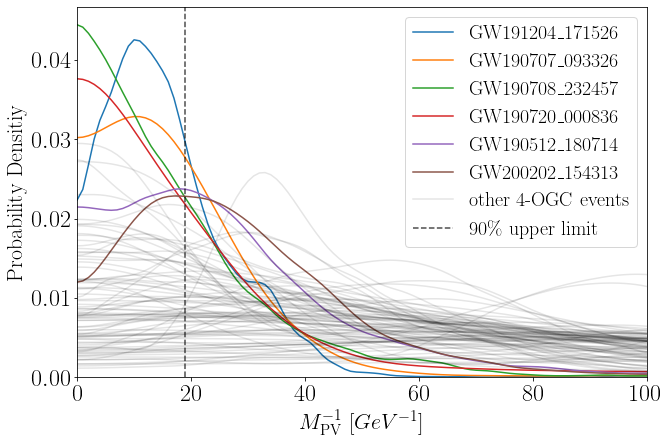

In [8]:
fig = plt.figure();
ax = fig.add_subplot(111)

combine = np.ones(len(bins[:-1]))
k = 0
for i in tqdm(mpvinv_90_arg):
#i is the sorted index for Mpvinv
    name = gwname[i]
    label = name.split('_')[0]+'\_'+name.split('_')[1]
    density = bounded_1d_kde(mpvinv[i], xlow=0., xhigh=200, method="Reflection")
    count = density(bins[:-1])
    #combine
    combine *= count
    #plot the most stringent six events with colored lines, and the rest with grey
    if k < 6:
        ax.plot(bins[:-1], count,label=label)
    elif k == 6:
        ax.plot(bins[:-1], count,color='black',alpha=0.1,label='other 4-OGC events')
    else:
        ax.plot(bins[:-1], count,color='black',alpha=0.1)
    k=k+1    
ax.set_xlim(0,100)
ax.set_ylim(0,)
ax.axvline(19,0,10,linestyle='--',color='black',alpha=0.7,label='$90\%$ upper limit')
ax.set_xlabel(r'$M_\mathrm{PV}^{-1}~[GeV^{-1}]$')
ax.set_ylabel('Probability Densitiy')
ax.legend()
#fig.savefig('mpv.pdf',bbox_inches='tight')

In [9]:
combine = combine / (np.sum(combine)*(bins[1]-bins[0]))
i = 0
while (np.sum(combine[:i]) * (bins[1]-bins[0])  <0.9):
    i = i+1
print('The upper limit for M_pv^-1 is:',bins[i-1])

The upper limit for M_pv^-1 is: 19.0


In [10]:
1/19

0.05263157894736842

# Plot subplots for presentation

In [11]:
sort = np.argsort(gwname)

In [12]:
import matplotlib.ticker as mticker

In [13]:
label_format = '{:,.0f}'

92it [01:18,  1.17it/s]


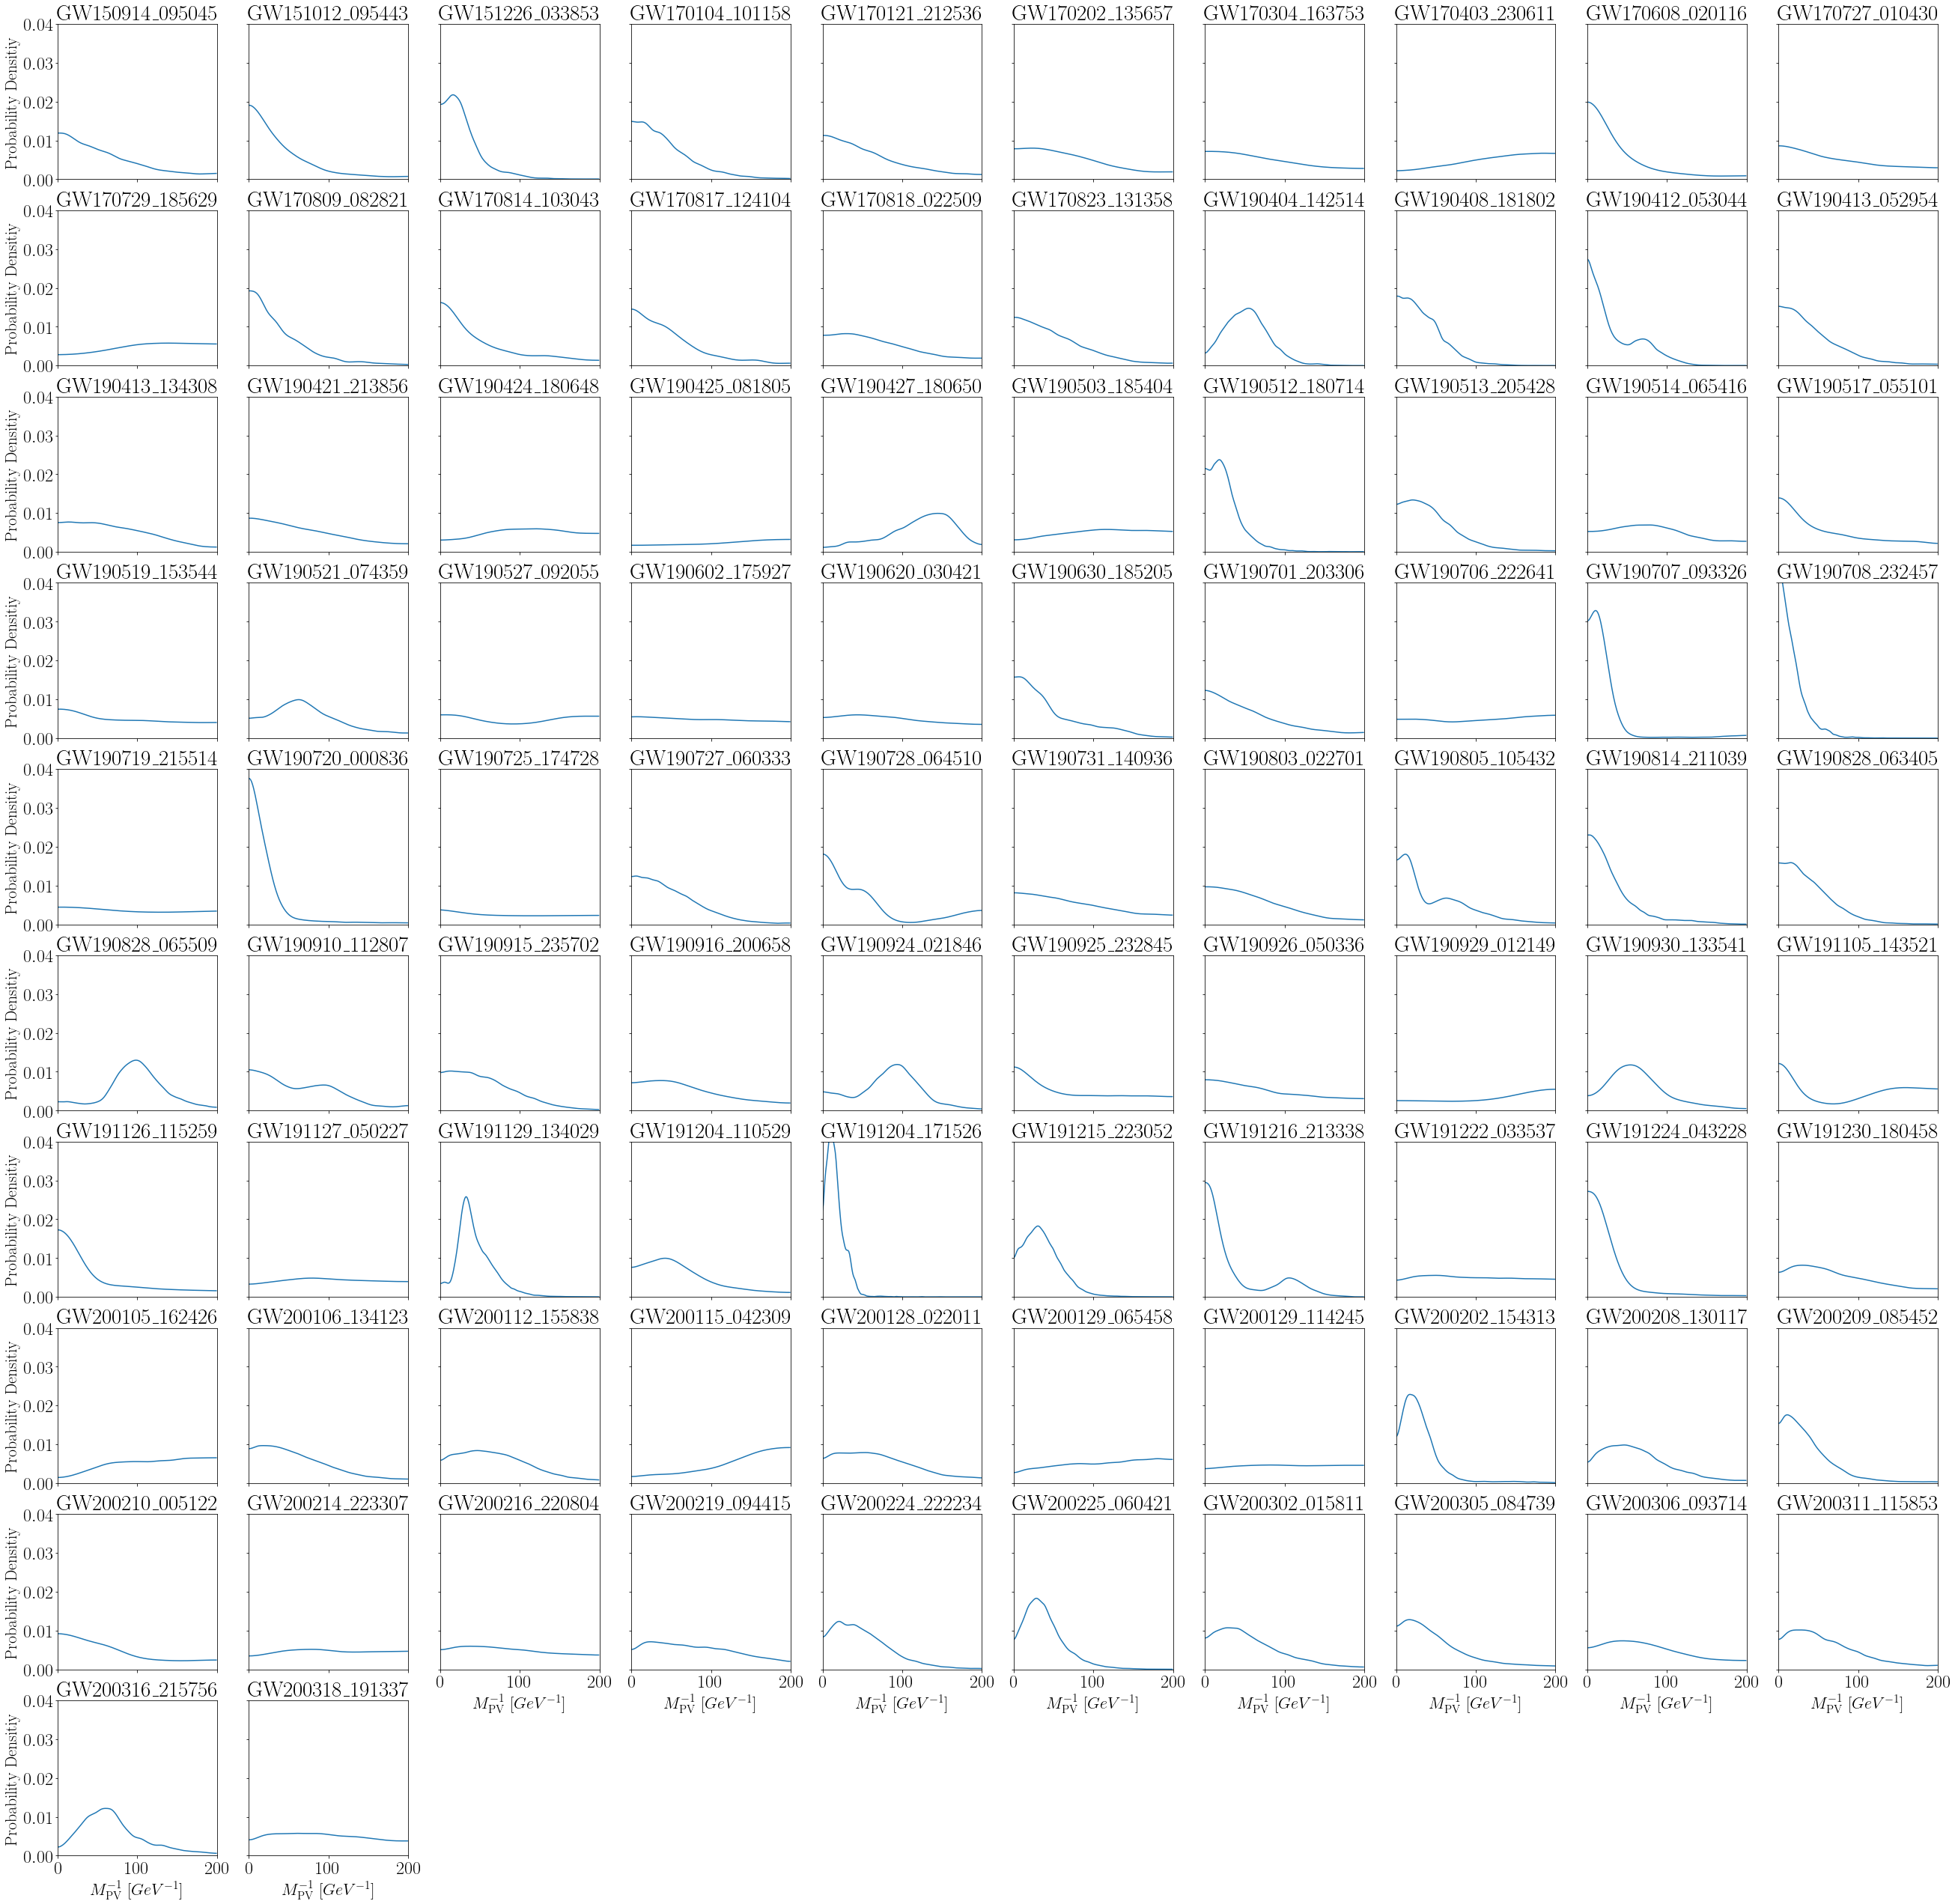

In [14]:
fig, axs = plt.subplots(10, 10,sharey=True,figsize=(45,45))
for y in range(2,10):
    fig.delaxes(axs[9][y])
for order,i in tqdm(enumerate(sort)):
    x = order // 10 
    y = order % 10
    
    name = gwname[i]
    label = name.split('_')[0]+'\_'+name.split('_')[1]
    density = bounded_1d_kde(mpvinv[i], xlow=0., xhigh=200, method="Reflection")
    count = density(bins[:-1])
    axs[x, y].plot(bins[:-1], count)
    axs[x, y].set_title(label)
    axs[x, y].set_xlim(0,200)
    axs[x, y].set_ylim(0,0.04)
    if y==0:
        axs[x,y].set_ylabel('Probability Densitiy')
    if x==9 or ((x==8) and (y>1)):
        axs[x,y].set_xlabel(r'$M_\mathrm{PV}^{-1}~[GeV^{-1}]$')
        
for y in [0,1]:
    for x in range(9):
        axs[x,y].get_shared_x_axes().join(axs[x,y], axs[9,y])
        axs[x,y].set_xticklabels([])

for y in range(2,10):
    for x in range(8):
        axs[x,y].get_shared_x_axes().join(axs[x,y], axs[8,y])
        axs[x,y].set_xticklabels([])

#fig.savefig('allresults-sortname-removelast8.pdf',bbox_inches='tight')